In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from utils import get_hash
from utils import Featurizer
from utils import plot_confusion_matrix

In [111]:
pd.set_option('display.max_colwidth', 1000)

In [2]:
# Create a featurizer object that converts a phrase into embedding vector
emb_file = os.path.join("munge", "GoogleNews-vectors-negative300.bin")
featurizer = Featurizer(emb_file)

Loading word vectors...
Done! Using 3000000 word vectors from pre-trained word2vec.


In [3]:
dev = pd.read_csv(os.path.join("munge", "dev.csv"))
dev.head()

,instance_id,student_id,task_id,problem_description,question,answer,reference_answers,label
0,644,DTSU034,FM_LVxx_PR02,A rocket is pushing a meteor with constant for...,How will the meteor move after the rocket stop...,The meteor will move with a constant velocity ...,"1: When the rocket stops pushing, no forces a...",1
1,841,DTSU002,FF_LV02_PR02.sh,A basketball player is dribbling a basketball ...,Because the ball's velocity is upward while th...,The ball's velocity is increasing.,1: The ball is slowing down at a constant rat...,2
2,122,DTSU039,FM_LV04_PR10.FCI-16.sh,"To rescue a child who has fallen down a well, ...",What can you say about the net force on the kid?,it equals zero,1: Since the child is being raised straight u...,0
3,827,DTSU010,FF_LV02_PR02,A basketball player is dribbling a basketball ...,What does Newton's second law tell you about t...,The acceleration of the ball is going in the s...,1: Since gravity is the only force acting on ...,0
4,755,DTSU002,LP03_PR12.push.accel.bMLK.sh,"While speeding up, a large truck pushes a smal...","How do the magnitudes, or amounts, of the forc...",The magnitudes are equal and opposite.,1: The force from the car on the truck and th...,0


In [31]:
landmarks = pd.read_csv(os.path.join("munge", "landmarks.txt"), sep="\t")
# Convert embeddings from string to list of floats
landmarks['embedding'] = landmarks['embedding'].apply(lambda x : list(map(float, x.split(','))))
landmarks.head()

,pd_hash,qu_hash,label,answer,embedding
0,5059c9cfbb,27570f5d10,0,An object at rest will stay at rest and at obj...,"[0.043226543225740134, 0.05086477179276316, 0...."
1,5059c9cfbb,27570f5d10,0,If all the forces acting on an object add up t...,"[0.032783322217987805, 0.03816697655654535, 0...."
2,5059c9cfbb,27570f5d10,0,When the object is in equilibrium or velocity ...,"[0.09235763549804688, 0.0213623046875, 0.06687..."
3,abb3be1545,c9b7df0ef8,0,"When the rocket stops pushing, no forces are a...","[0.031693892045454544, 0.05947598544034091, -0..."
4,abb3be1545,c9b7df0ef8,0,"When the rocket stops pushing, the meteor will...","[0.04916178385416667, 0.09795735677083334, -0...."


In [32]:
dev['pd_hash'] = dev['problem_description'].apply(get_hash)
dev['qu_hash'] = dev['question'].apply(get_hash)
dev['embedding'] = dev['answer'].apply(featurizer.doc2vec)

In [118]:
def get_prediction(landmarks, k, pd_hash, qu_hash, emb):
    
    # Filter on question of concern
    qu_land = landmarks[(landmarks['pd_hash'] == pd_hash) & (landmarks['qu_hash'] == qu_hash)].copy()
    # Compute answer similarity to all landmarks
    qu_land['similarity'] = qu_land['embedding'].apply(lambda x : featurizer.cossim_from_emb(emb, np.array(x)))
    qu_land['similarity'] = np.round(qu_land['similarity'], 6)
    # Sort in descending order of similarity
    qu_land = qu_land.sort_values('similarity', ascending=False)
    # keep top k nearest neighbors
    qu_land =  qu_land.head(k)
    # Find majority class in top k
    prediction = qu_land['label'].value_counts().index.values[0]
    
    return prediction

In [119]:
# Compute predictions
dev['pred'] = dev.apply(lambda line: get_prediction(landmarks,
                                                    1,
                                                    line['pd_hash'],
                                                    line['qu_hash'],
                                                    line['embedding']),
                        axis=1)

# Performance Evaluation

In [120]:
# predictions 
pred = np.array(dev['pred'])
pred

array([0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 0, 3, 0, 3, 2,
       0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 0, 3, 0, 0, 3, 1, 3, 0, 1, 0,
       1, 0, 2, 2, 1, 3, 0, 0, 2, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0,
       3, 0, 1, 0, 1, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0,
       0, 1, 2, 3, 1, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 1, 0, 0, 1,
       2, 0, 0, 1, 1, 0, 3, 2, 3, 0, 0, 3, 0, 2, 0, 3, 2, 0, 1, 3, 0, 0,
       3, 0, 0, 1])

In [121]:
labels = np.array(dev['label'])
labels

array([1, 2, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 3, 3, 0, 3, 0, 1, 3, 0, 0,
       0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 0, 3, 1, 3, 1, 0, 2, 0, 1, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 2,
       1, 1, 0, 1, 3, 2, 0, 0, 1, 1, 3, 1, 0, 3, 3, 0, 2, 0, 3, 0, 1, 0,
       1, 0, 3, 1, 1, 3, 2, 0, 3, 0, 1, 1, 1, 0, 3, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 3, 2, 3, 1, 1, 0,
       0, 3, 2, 3, 1, 0, 3, 0, 0, 1, 0, 1, 1, 3, 1, 2, 0, 0, 1, 1, 0, 1,
       2, 0, 3, 1, 1, 0, 3, 1, 2, 0, 0, 0, 3, 2, 3, 2, 2, 0, 1, 3, 2, 0,
       1, 0, 3, 0])

## Accuracy

In [122]:
# Final accuracy
acc = np.round(np.mean(labels == pred),6)
print("Original performance")
print('Accuracy: {}'.format(acc))

Original performance
Accuracy: 0.577778


## Confusion Matrix

Confusion matrix, without normalization
[[60  7  3  7]
 [19 20  2  3]
 [ 3  0  9  5]
 [21  3  3 15]]


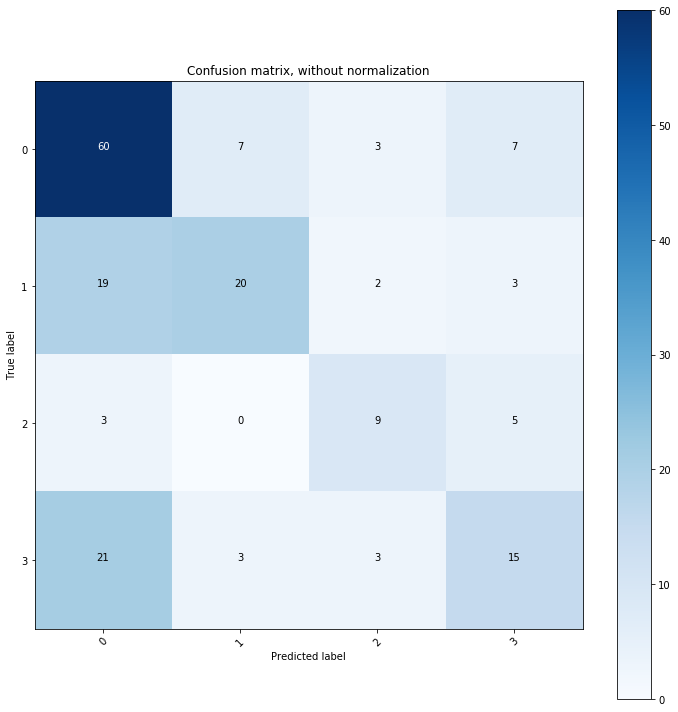

In [102]:
class_names = list(np.unique(labels))

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.Blues)

## Classification Report

In [103]:
# Compute classification report
clf_report = classification_report(labels, pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.58      0.78      0.67        77
           1       0.67      0.45      0.54        44
           2       0.53      0.53      0.53        17
           3       0.50      0.36      0.42        42

   micro avg       0.58      0.58      0.58       180
   macro avg       0.57      0.53      0.54       180
weighted avg       0.58      0.58      0.56       180



# Error Analysis

In [123]:
dev[(dev['label']==3) & (dev['pred']==3)]

,instance_id,student_id,task_id,problem_description,question,answer,reference_answers,label,pd_hash,qu_hash,embedding,pred
14,495,DTSU021,Demo_LP01_PR01,A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal.,Can you articulate the definition or principle that helps us determine the forces?,newtons 3rd law,"1: An object at rest will stay at rest and an object moving with constant velocity in a straight line will continue moving with constant velocity in a straight line as long as the net force acting on the object is zero. 2: When the object is in equilibrium or velocity is constant, the sum of all forces will equal 0 3: If the acceleration of a system is zero, the summation of the forces is also zero",3,b595153926,89f68d499a,"[0.07877604166666667, -0.054361979166666664, 0.15218098958333334, 0.08170572916666667, -0.14241536458333334, -0.07171630859375, -0.10123697916666667, -0.029500325520833332, 0.080810546875, 0.1151123046875, -0.06754557291666667, -0.08939615885416667, -0.13321940104166666, 0.09895833333333333, -0.16451009114583334, 0.10481770833333333, -0.038411458333333336, 0.0888671875, -0.16471354166666666, -0.15169270833333334, -0.034261067708333336, -0.07320149739583333, 0.05126953125, 0.0035502115885416665, 0.01123046875, -0.21451822916666666, -0.04476165771484375, 0.12858072916666666, -0.07975260416666667, 0.09407552083333333, -0.1328125, -0.22623697916666666, 0.13755289713541666, 0.0096435546875, -0.004496256510416667, -0.0731201171875, 0.005289713541666667, 0.2906901041666667, -0.10068766276041667, 0.11783854166666667, 0.06998697916666667, -0.04052734375, 0.10693359375, 0.09912109375, -0.00016276041666666666, 0.09326171875, 0.01568603515625, 0.017333984375, 0.014892578125, -0.002115885416666...",3
16,456,DTSU039,FM_LV04_PR05.sh,Two hockey players pass a puck between them on an ice rink. Assume that the ice is very smooth so that there is no friction.,What can you say about the net horizontal force on the puck while moving on the ice between the players?,it is balanced,"1: Since there are no forces acting on the puck in the horizontal direction, the net horizontal force is zero. 2: The net horizontal force is zero.",3,35db126042,a5c3be16a4,"[0.000885009765625, 0.0050907135009765625, 0.028157552083333332, 0.08028157552083333, -0.1220703125, -0.010416666666666666, 0.118896484375, -0.059590657552083336, 0.06591796875, -0.013468424479166666, -0.08463541666666667, -0.10392252604166667, 0.015523274739583334, 0.020182291666666668, 0.027669270833333332, 0.0899658203125, 0.012064615885416666, 0.06331380208333333, 0.009073893229166666, -0.046712239583333336, 0.023356119791666668, 0.20621744791666666, 0.053304036458333336, 0.0194091796875, 0.07918294270833333, 0.033528645833333336, -0.11214192708333333, 0.102783203125, 0.060282389322916664, 0.061604817708333336, -0.025227864583333332, 0.033854166666666664, -0.02978515625, 0.02880859375, 0.13020833333333334, 0.017985026041666668, -0.06504313151041667, 0.048065185546875, 0.10123697916666667, 0.0908203125, 0.10872395833333333, -0.01904296875, 0.018513997395833332, 0.026936848958333332, 8.138020833333333e-05, 0.10756429036458333, 0.015706380208333332, 0.06522623697916667, 0.07727050...",3
35,197,DTSU014,Demo_LP01_PR01.sh,A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal.,What forces are acting on the box? Which forces balance each other?,The forces acting upon the box in the y direction are normal force and gravity. These two forces balance each other therefore the box does not move up or down. The forces acting upon the box in the x direction are the horizontal push from the person and friction from the carpet. These two forces do not balance each other out since the box is moving. the push force exerted by the person must be more than the frictional force in order for the box to move.,"1: The forces are the force of the mover pushing